## AI Fashion Classification
### Jo Yeongtak - SEOUL, SEWON ATOS

In [27]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [28]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

import os
import numpy as np

import tensorflow as tf
import datetime

# Clear any logs from previous runs
!rm -rf ./logs/ 

In [29]:
#Build a model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs) # ON
    #x = inputs #OFF
    print(x.shape)
    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    print(x.shape)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    x = layers.SeparableConv2D(2048, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [30]:
#Filter out corrupted images
num_skipped = 0
for folder_name in ("dress", "outer", "pants", "skirt", "suit", "top"):
    folder_path = os.path.join("dataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        fobj = open(fpath, "rb")
        if tf.compat.as_bytes("JFIF") not in fobj.peek(10):
            num_skipped += 1
            # Delete corrupted image
            os.system("rm " + fpath)
print("Deleted %d images" % num_skipped)

Deleted 6 images


In [31]:
#Generate a Dataset
image_size = (225, 225)
batch_size = 4

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 22105 files belonging to 6 classes.
Using 17684 files for training.
Found 22105 files belonging to 6 classes.
Using 4421 files for validation.


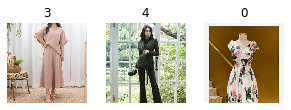

In [32]:
#Visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

plt.show()

In [33]:
#Using image data augmentation
data_augmentation = keras.Sequential(
     [
         layers.experimental.preprocessing.RandomFlip("horizontal"),
         layers.experimental.preprocessing.RandomRotation(0.02),
     ])

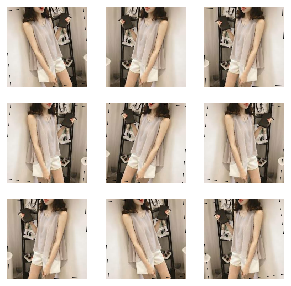

In [34]:
plt.figure(figsize=(5, 5))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.show()

In [35]:
#Build a model
model = make_model(input_shape=image_size + (3,), num_classes=6)
print(str(image_size + (3,)))

keras.utils.plot_model(model, show_shapes=True)

train_ds = train_ds.prefetch(buffer_size=64)
val_ds = val_ds.prefetch(buffer_size=64)

(None, 225, 225, 3)
(None, 225, 225, 3)
(225, 225, 3)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [36]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [37]:
#Train the model
epochs = 300

callbacks = [
   keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5", save_best_only=True),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + time
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(
    train_ds, epochs=epochs, callbacks=[callbacks, tensorboard_callback, earlystopping], validation_data=val_ds, batch_size = 4) # callbacks = [callbacks, tensorboard_callback, earlystopping]

Epoch 1/300
4421/4421 [==============================] - 167s 38ms/step - loss: 2.1126 - accuracy: 0.2134 - val_loss: 1.7811 - val_accuracy: 0.2995
Epoch 2/300
4421/4421 [==============================] - 168s 38ms/step - loss: 1.6509 - accuracy: 0.3262 - val_loss: 1.4934 - val_accuracy: 0.3979
Epoch 3/300
4421/4421 [==============================] - 170s 38ms/step - loss: 1.4667 - accuracy: 0.4178 - val_loss: 1.2996 - val_accuracy: 0.5051
Epoch 4/300
4421/4421 [==============================] - 171s 39ms/step - loss: 1.3489 - accuracy: 0.4711 - val_loss: 1.2930 - val_accuracy: 0.5006
Epoch 5/300
4421/4421 [==============================] - 170s 39ms/step - loss: 1.2479 - accuracy: 0.5166 - val_loss: 1.3028 - val_accuracy: 0.5089
Epoch 6/300
4421/4421 [==============================] - 169s 38ms/step - loss: 1.1725 - accuracy: 0.5561 - val_loss: 1.1543 - val_accuracy: 0.5709
Epoch 7/300
4421/4421 [==============================] - 174s 39ms/step - loss: 1.1128 - accuracy: 0.5839 - val_

In [38]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 225, 225, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 225, 225, 3)  0           sequential_2[0][0]               
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 113, 113, 32) 896         rescaling_2[0][0]                
____________________________________________________________________________________________

In [39]:
if not os.path.exists('models/'):
        os.mkdir('models/')

model.save("models/" + time + "-model.h5")

In [50]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 22972), started 4 days, 22:03:54 ago. (Use '!kill 22972' to kill it.)

In [14]:
p_list = { 0:"dress", 1:"outer", 2:"pants", 3:"skirt", 4:"suit", 5:"top"}

#Prediction Sample Image
img = keras.preprocessing.image.load_img(
    "example/mtb3.PNG", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
result = np.argmax(predictions[0])

for i in range(np.shape(predictions)[1]):
    print(p_list[i], round(predictions[0][i] * 100, 2))

dress 99.25
outer 0.06
pants 0.0
skirt 0.48
suit 0.01
top 0.21


In [1]:
print('a' + 'b')

ab


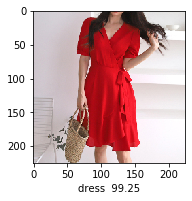

In [15]:
plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap=plt.cm.binary)
plt.xlabel(str(p_list[result]) + '  ' + str(round((np.max(predictions) * 100), 2)))
plt.show()

In [54]:
p_list = { 0:"dress", 1:"outer", 2:"pants", 3:"skirt", 4:"suit", 5:"top"}

In [2]:
model = keras.models.load_model('models/20200602-104256-model.h5')

NameError: name 'keras' is not defined

In [1]:
from flask import Flask, render_template, request, redirect, url_for, send_from_directory
from werkzeug.utils import secure_filename

app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/cnn')
def cnn():
    return render_template('cnn.html')

@app.route('/nlp')
def nlp():
    return render_template('nlp.html')

@app.route('/files/<path:filename>', methods = ['GET', 'POST'])
def download_file(filename):
    return send_from_directory("files",filename, as_attachment=True)

@app.route('/uploader', methods = ['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        f = request.files['file']
        f.save(f'user/{secure_filename(f.filename)}')
        
        #Prediction Sample Image
        img = keras.preprocessing.image.load_img(
            "user/" + f.filename, target_size=image_size
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis

        predictions = model.predict(img_array)
        result = np.argmax(predictions[0])
            
        plt.figure(figsize=(6,3))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(str(p_list[result]) + '  ' + str(round((np.max(predictions) * 100), 2)))
        plt.savefig('static/img/fig/' + f.filename, dpi=800)
        
        return '<img src=''static/img/fig/' + f.filename+''' width="800">''<p> <a href="http://121.140.112.233/cnn">돌아가기</a>'''
		
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=80)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:80/ (Press CTRL+C to quit)
121.140.112.233 - - [03/Jun/2020 16:48:43] "GET / HTTP/1.1" 200 -
121.140.112.233 - - [03/Jun/2020 16:48:43] "GET /favicon.ico HTTP/1.1" 404 -
121.140.112.233 - - [03/Jun/2020 16:48:46] "GET /cnn HTTP/1.1" 200 -
121.140.112.233 - - [03/Jun/2020 16:48:46] "GET /cnn HTTP/1.1" 200 -
[2020-06-03 16:48:50,002] ERROR in app: Exception on /uploader [POST]
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\flask\app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\ProgramData\Anaconda3\lib\site-packages\flask\app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\ProgramData\Anaconda3\lib\site-packages\flask\app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\ProgramData\Anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "C:\ProgramData\Anaconda3\lib\si